# Apply CellCap to simulation data

This tutorial shows how to setup CellCap for dissecting perturbation programs in simulation data. The simulation data has a simple setup, with two perturbation conditions and one control group. The control group covers two cell states, and two perturbations would induce two distinct programs in a cell state A, while sharing one program in the other cell state B. The goal here is to identify these two programs are specific to these two perturbations and cell state A. At the same time, CellCap should reveal the the shared program is specific to cell state B.

Through this tutorial, we will primarily show hyperparameter setup is critical for CellCap to model the correspondece between cellular identity and perturbation response. A few examples below will show that CellCap reaches to different conclusions due to different hyperparameter setups.

* [Load packages](#Load-packages)
* [Prepare data for ready-to-use](#Prepare-data)
* [Learning good basal state is critical for establishing correspondence between cellular identity and perturbation response](#Basal-state)
   1. [Train CellCap without adversarial loss](#no-adversarial)
   2. [A small penalty on adversarial learning](#small-adversarial)
   3. [Keep the penalty on adversarial learning large](#large-adversarial)
* [A structured outcome requires tuning penalty on automatic relevance determination](#ARD)
* [The right solution for this simulation data](#Right-solution)

## Load packages <a class="anchor" id="Load-packages"></a>

In [1]:
import torch

import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import scvi
scvi.settings.seed = 3

from cellcap.scvi_module import CellCap
from cellcap.validation.plot import plot_adversarial_classifier_roc, plot_program_usage

Global seed set to 0
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Global seed set to 3


In [5]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True)

## Prepare data for ready-to-use <a class="anchor" id="Prepare-data"></a>

In [6]:
adata = sc.read_h5ad('../data/simulation_data.h5ad')
adata.layers["counts"] = adata.X.copy()

In [7]:
codes, uniques = pd.factorize(adata.obs['Condition'])
uniques = list(uniques)
adata.obs['condition']=codes

In [8]:
drug_names = uniques.copy()
drug_names.remove('Control')

# one-hot encoding of perturbation information
target_label = np.zeros((len(codes),len(uniques)))
for i in range(len(codes)):
    j = codes[i]
    target_label[i,j]=1
class_weight = target_label.copy()
target_label[:,uniques.index('Control')]=0
target_label = target_label[:,np.sum(target_label,0)>0]
adata.obsm['X_target']=target_label
print(target_label.shape)

(6000, 2)


In [9]:
#create dummpy covariance factor
covarY = np.zeros((len(codes),1))
adata.obsm['X_covar']=covarY

## Learning good basal state is critical for establishing correspondence between cellular identity and perturbation response <a class="anchor" id="Basal-state"></a>

In this section, we will show that learning good basal state is a critical step to model correspondence between cellular identity and perturbation response. CellCap approximates basal state via adervarial learning. The hyperparameter `lamda` controls the weight of adversarial loss in the total loss objective. To learn good basal state, users can focus on increasing or decreasing `lamda`. To judge if CellCap appromixates good state, we use receiver operating characteristic curve (ROC curve) to show if perturbations are no longer distinguiable from control group.

## 1. Train CellCap without adversarial loss <a class="anchor" id="no-adversarial"></a>
We first train CellCap without adversarial learning. Here, we set `lamda` as 0, which sets zero contribution of adversarial loss in the total loss objective.

In [10]:
CellCap.setup_anndata(adata, layer="counts", target_key='X_target', covar_key='X_covar')

cellcap = CellCap(adata, n_latent=10, n_layers=3, n_drug=2, n_covar=1, ard_kl_weight=1.0, lamda=0.0)

cellcap.train(max_epochs=1000, batch_size=256)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:49<00:00,  2.78it/s, loss=2.02e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s, loss=2.02e+03, v_num=1]


In [11]:
#get latent representation of basal state
z = cellcap.get_latent_embedding(adata,batch_size=256)
adata.obsm['X_basal']=z

Control (AUC = 1.0000)
Perturbation1 (AUC = 0.9993)
Perturbation2 (AUC = 0.9992)


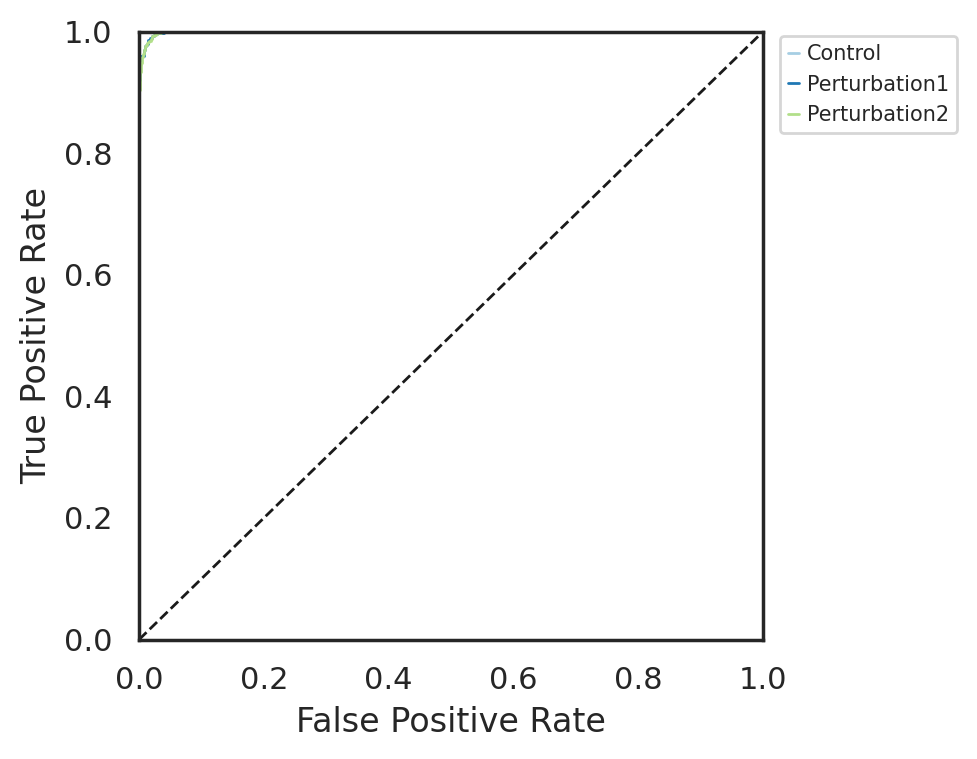

In [12]:
plot_adversarial_classifier_roc(
    adata=adata,
    perturbation_key='Condition',
)

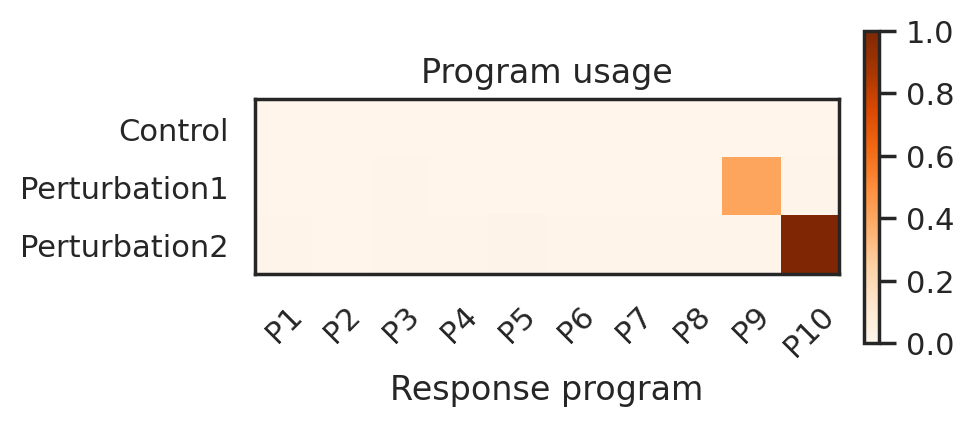

In [13]:
df_usage = plot_program_usage(
    cellcap=cellcap,
    adata=adata,
    perturbation_key='Condition',
)

Classifier using latent representation of basal state can accurately distinguish perturbation conditions from control, indicating three conditions are not mixed in the latent space. This is not a good solution to basal state. As a result, program usage suggests that CellCap did not identify 3 programs (1 shared and 2 unique programs).

## 2. A small penalty on adversarial learning <a class="anchor" id="small-adversarial"></a>
We then increase lamda a little bit and train CellCap again. We set `lamda` as 0.1 this time.

In [14]:
CellCap.setup_anndata(adata, layer="counts", target_key='X_target', covar_key='X_covar')

cellcap = CellCap(adata, n_latent=10, n_layers=3, n_drug=2, n_covar=1, ard_kl_weight=1.0, lamda=0.1)

cellcap.train(max_epochs=1000, batch_size=256)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 892/1000:  89%|████████▉ | 892/1000 [06:02<00:43,  2.46it/s, loss=2.07e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 2190.925. Signaling Trainer to stop.


In [15]:
#get latent representation of basal state
z = cellcap.get_latent_embedding(adata,batch_size=256)
adata.obsm['X_basal']=z

Control (AUC = 0.7417)
Perturbation1 (AUC = 0.6075)
Perturbation2 (AUC = 0.6241)


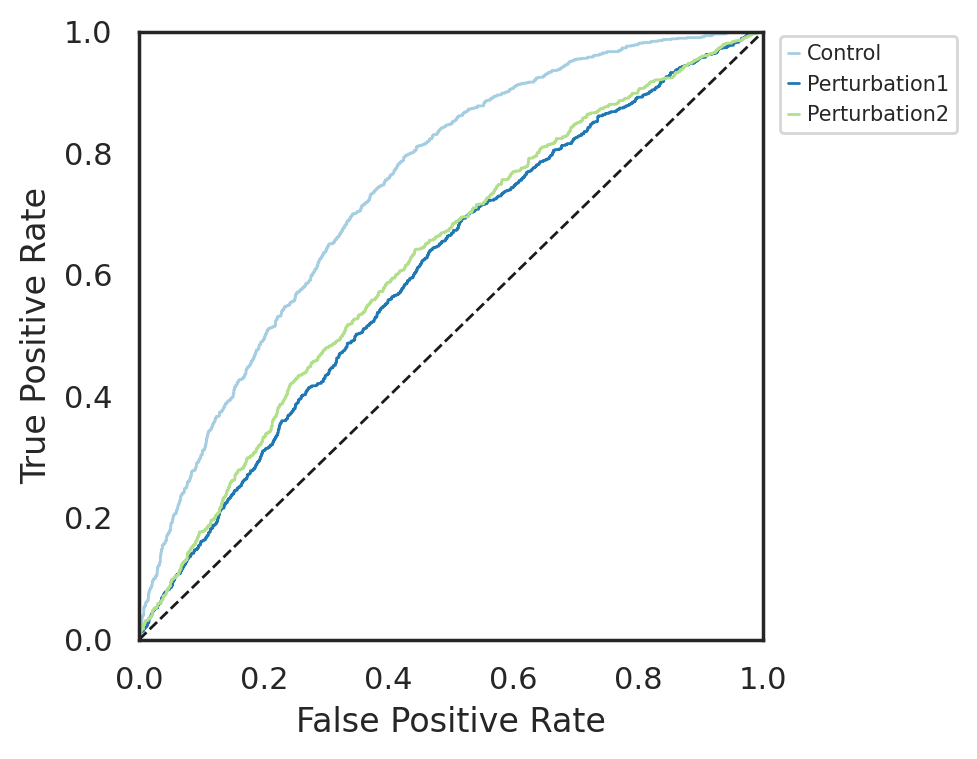

In [16]:
plot_adversarial_classifier_roc(
    adata=adata,
    perturbation_key='Condition',
)

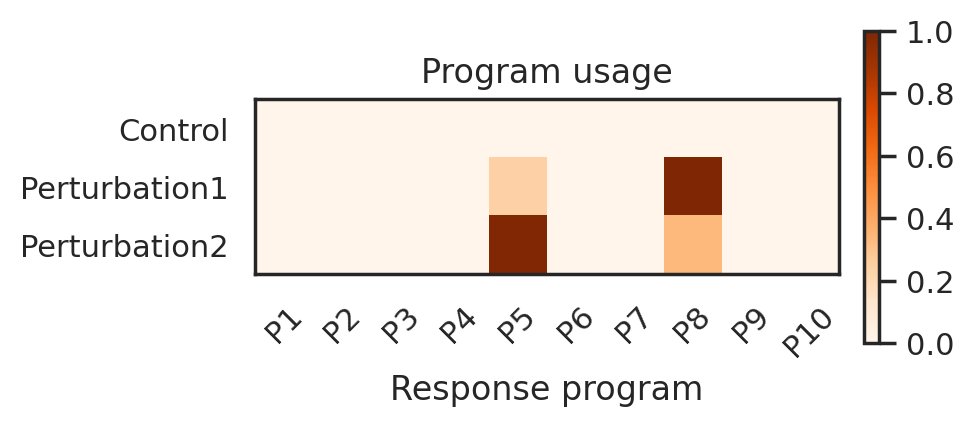

In [17]:
df_usage = plot_program_usage(
    cellcap=cellcap,
    adata=adata,
    perturbation_key='Condition',
)

After increaing `lamda` a little, classifier is able to achieve lower AUC scores for three conditions, suggesting improvement of condition mixing. As a result, CellCap learns two programs that are mainly specific two perturbations respectively. However, CellCap fails to recover the shared program.

## 3. Keep the penalty on adversarial learning large <a class="anchor" id="large-adversarial"></a>
Outcomes above suggest a larger lamda would be a safe practice to train CellCap. In most cases, we set `lamda` as 1.0.

In [18]:
CellCap.setup_anndata(adata, layer="counts", target_key='X_target', covar_key='X_covar')

cellcap = CellCap(adata, n_latent=10, n_layers=3, n_drug=2, n_covar=1, ard_kl_weight=1.0, lamda=1.0)

cellcap.train(max_epochs=1000, batch_size=256)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 972/1000:  97%|█████████▋| 972/1000 [06:26<00:11,  2.51it/s, loss=2.36e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 2191.340. Signaling Trainer to stop.


In [19]:
#get latent representation of basal state
z = cellcap.get_latent_embedding(adata,batch_size=256)
adata.obsm['X_basal']=z

Control (AUC = 0.5068)
Perturbation1 (AUC = 0.4898)
Perturbation2 (AUC = 0.4760)


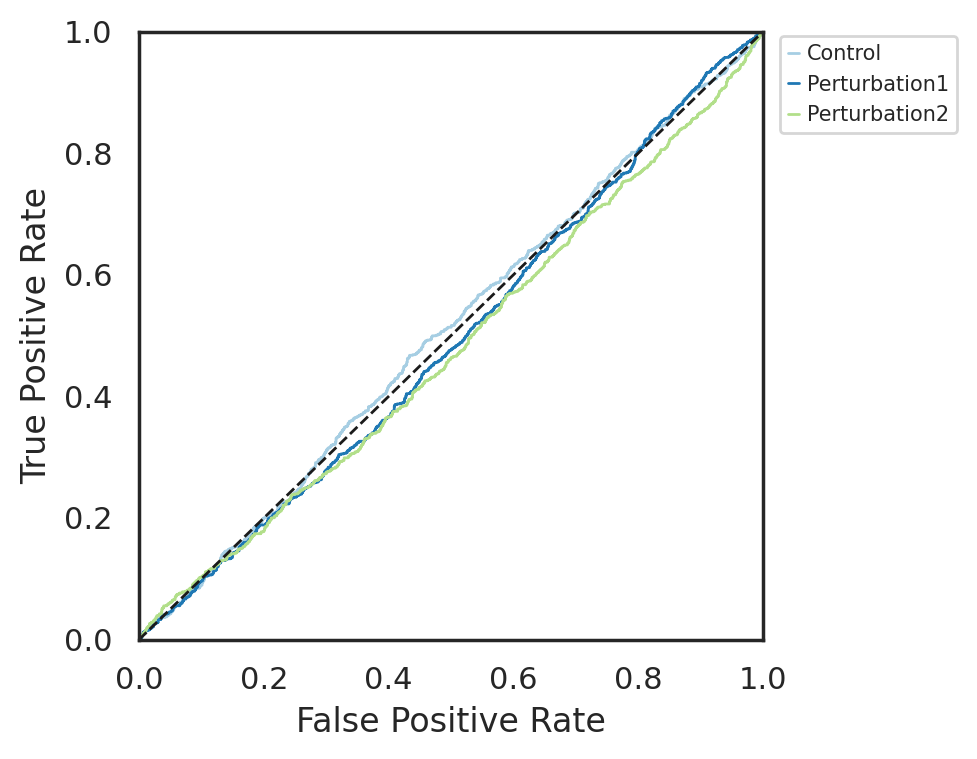

In [20]:
plot_adversarial_classifier_roc(
    adata=adata,
    perturbation_key='Condition',
)

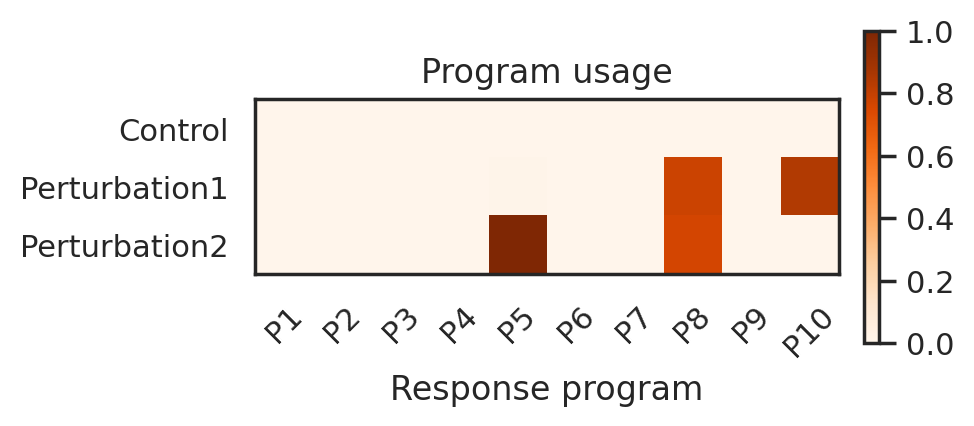

In [21]:
df_usage = plot_program_usage(
    cellcap=cellcap,
    adata=adata,
    perturbation_key='Condition',
)

Finally, with `lamda` as 1, CellCap identified 3 programs (1 shared and 2 unique programs).

## A structured outcome requires tuning penalty on automatic relevance determination <a class="anchor" id="ARD"></a>
In this section, we will twist another hyperparameter in CellCap, `ard_kl_weight`. We will start with a small `ard_kl_weight` and then increase it gradually to train CellCap again. We will show how this hyperparameter has impacts on structuring perturbation programs, through visualizing the learnable parameter `H`. In CellCap, `H` represents how relevant a perturbation program is to the perturbation.

First, we set `ard_kl_weight` as 0.2.

In [22]:
#ard_kl_weight = 0.2
CellCap.setup_anndata(adata, layer="counts", target_key='X_target', covar_key='X_covar')

cellcap = CellCap(adata, n_latent=10, n_layers=3, n_drug=2, n_covar=1, ard_kl_weight=0.2, lamda=1.0)

cellcap.train(max_epochs=1000, batch_size=256)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:36<00:00,  2.87it/s, loss=2.47e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s, loss=2.47e+03, v_num=1]


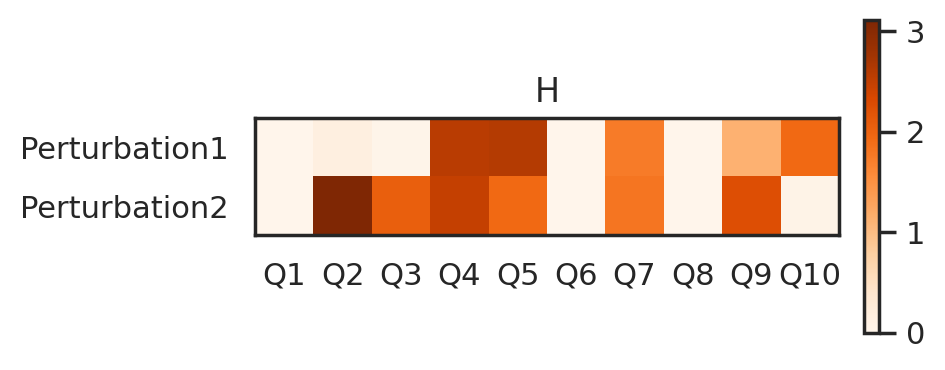

In [23]:
h = cellcap.get_h()
h = pd.DataFrame(h)
h.index = drug_names
h.columns = ['Q'+str(i) for i in range(10)]

#plotting
sns.set_theme(style='white', font_scale=1)
im = plt.imshow(h.to_numpy(), cmap="Oranges", vmin=0)
plt.grid(False)
plt.xticks(
    ticks=range(h.shape[1]),
    labels=["Q"+ str(i+1) for i in range(h.shape[1])],
    # rotation=45
)
plt.yticks(
    ticks=range(2),
    labels=h.index,
    # rotation=45
)
plt.title("H")
plt.colorbar(im, fraction=0.025, pad=0.04)

With a small `ard_kl_weight`, CellCap takes advantage of allocatable dimension of `H`. As shown in the heatmap above, CellCap loosely identified Q4, Q5, Q7, and Q9 as shared program, while we believe these 4 programs should be merged as one. For perturbation-specific programs, CellCap also used Q2 and Q3 to represent the unique program and the only one for perturbation 2.

In the second trial, we set `ard_kl_weight` as 0.5.

In [24]:
#ard_kl_weight = 0.5
CellCap.setup_anndata(adata, layer="counts", target_key='X_target', covar_key='X_covar')

cellcap = CellCap(adata, n_latent=10, n_layers=3, n_drug=2, n_covar=1, ard_kl_weight=0.5, lamda=1.0)

cellcap.train(max_epochs=1000, batch_size=256)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:25<00:00,  2.88it/s, loss=2.44e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s, loss=2.44e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 2190.651. Signaling Trainer to stop.


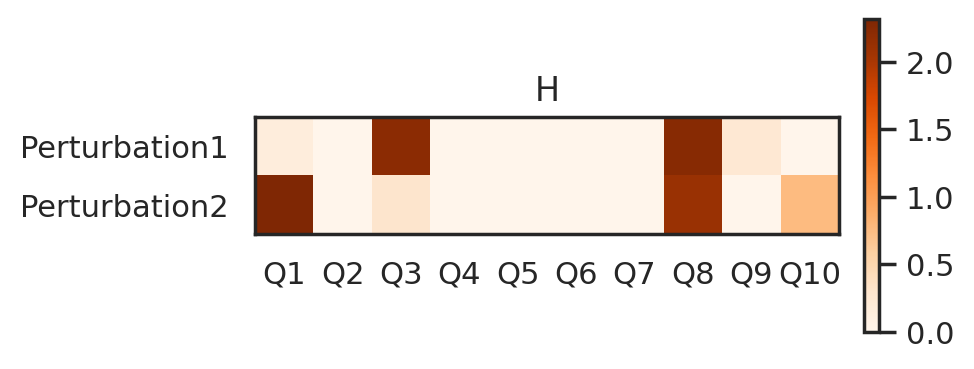

In [25]:
h = cellcap.get_h()
h = pd.DataFrame(h)
h.index = drug_names
h.columns = ['Q'+str(i) for i in range(10)]

#plotting
sns.set_theme(style='white', font_scale=1)
im = plt.imshow(h.to_numpy(), cmap="Oranges", vmin=0)
plt.grid(False)
plt.xticks(
    ticks=range(h.shape[1]),
    labels=["Q"+ str(i+1) for i in range(h.shape[1])],
    # rotation=45
)
plt.yticks(
    ticks=range(2),
    labels=h.index,
    # rotation=45
)
plt.title("H")
plt.colorbar(im, fraction=0.025, pad=0.04)

`ard_kl_weight` as 0.5 greatly improved the structure of table `H`. CellCap identified a single shared program Q8. However, there is a small struggle on learning the unique program for perturbation 2. Though Q1 is indicated as the strongest program specific to perturbation 2, Q10 is slightly revelant to perturbation 2.

Finally, we increase `ard_kl_weight` to 1.0.

In [26]:
#ard_kl_weight = 1.0
CellCap.setup_anndata(adata, layer="counts", target_key='X_target', covar_key='X_covar')

cellcap = CellCap(adata, n_latent=10, n_layers=3, n_drug=2, n_covar=1, ard_kl_weight=1.0, lamda=1.0)

cellcap.train(max_epochs=1000, batch_size=256)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 927/1000:  93%|█████████▎| 927/1000 [06:04<00:28,  2.54it/s, loss=2.36e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 2190.828. Signaling Trainer to stop.


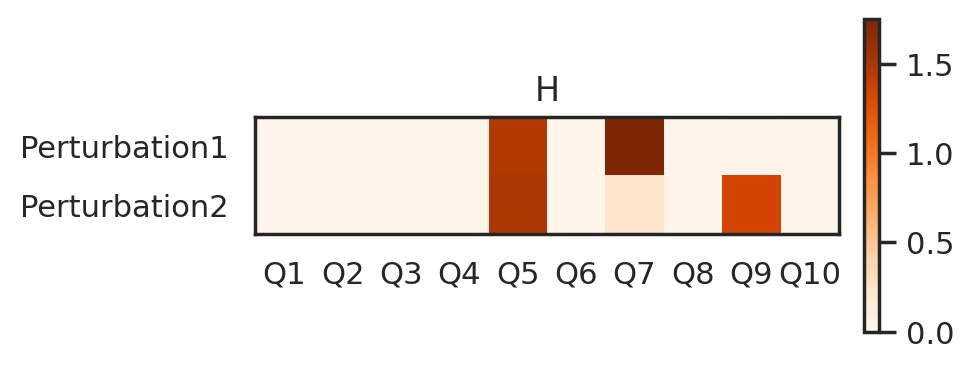

In [27]:
h = cellcap.get_h()
h = pd.DataFrame(h)
h.index = drug_names
h.columns = ['Q'+str(i) for i in range(10)]

#plotting
sns.set_theme(style='white', font_scale=1)
im = plt.imshow(h.to_numpy(), cmap="Oranges", vmin=0)
plt.grid(False)
plt.xticks(
    ticks=range(h.shape[1]),
    labels=["Q"+ str(i+1) for i in range(h.shape[1])],
    # rotation=45
)
plt.yticks(
    ticks=range(2),
    labels=h.index,
    # rotation=45
)
plt.title("H")
plt.colorbar(im, fraction=0.025, pad=0.04)

The new table of `H` shows that CellCap dissected 3 perturbation programs in this simulation data. Q7 is specific to perturbation 1, Q9 is specific to perturbation 2, and Q5 as shared one for both perturbations.

## The right solution for this simulation data <a class="anchor" id="Right-solution"></a>
Based on results in previous sections, we finally can set up a good set of hyperparameters to reach the right solution for this simulation data. The last section in this tutorial will show how CellCap correctly identify correspondence between cellular identity and perturbation response. As we described in the beginning of this tutorial, two unique programs are specific cell state A, and the shared program is specific to cell state B. We will other visualization approaches to demonstrate that CellCap recovers this information out from the simulation data.

In [28]:
#ard_kl_weight = 1.0, and lamda = 1.0
CellCap.setup_anndata(adata, layer="counts", target_key='X_target', covar_key='X_covar')

cellcap = CellCap(adata, n_latent=10, n_layers=3, n_drug=2, n_covar=1, ard_kl_weight=1.0, lamda=1.0)

cellcap.train(max_epochs=1000, batch_size=256)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 943/1000:  94%|█████████▍| 943/1000 [06:15<00:22,  2.51it/s, loss=2.36e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 2191.020. Signaling Trainer to stop.


In [29]:
z = cellcap.get_latent_embedding(adata,batch_size=256)
_, zH, _ = cellcap.get_pert_embedding(adata)

scaler = MinMaxScaler((0,1))
zH_scaled = scaler.fit_transform(zH)

adata.obsm['X_basal']=z
adata.obsm['X_h_scaled']=zH_scaled

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_basal', random_state=0, metric='cosine')
sc.tl.draw_graph(adata, layout='fr')

We differentiated response amplitutes by utlizing the pseudotime, when we set up the simulation data. Cells with higher pseudotime values tend to have higher responses of two unique programs in both perturbation conditions, while cells with lower pseudotime have higher reponses of the shared program Thus, pseudotime will serve as groundtruth to evaluate learned programs by CellCap. We expect the response amplitudes learnd by CellCap would be correlated with pseudotime for both unique programs but anti-correlated for the shared program.

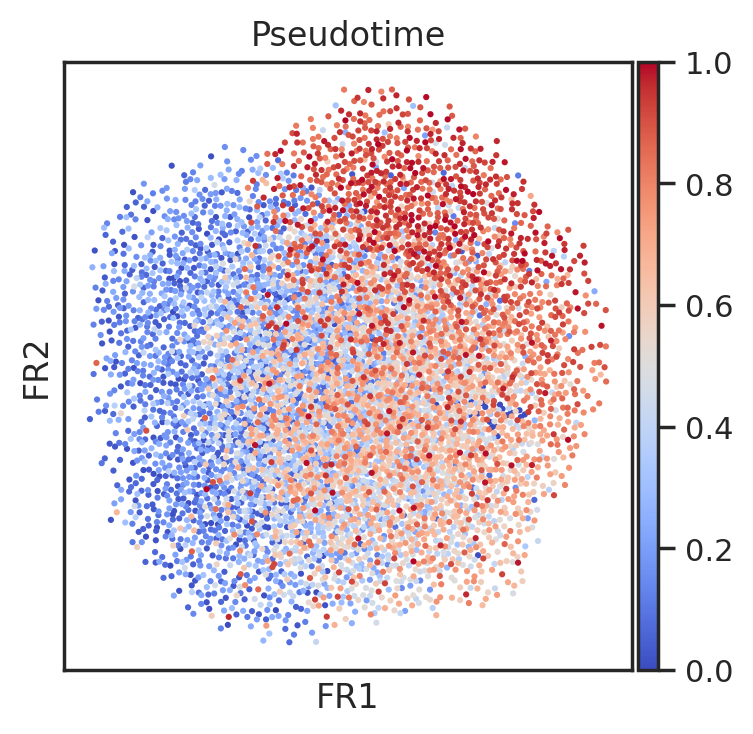

In [31]:
sc.pl.draw_graph(adata, color=['Pseudotime'], ncols=1, cmap='coolwarm', vmin=0, vmax=1)

Now we visualize patterns of perturbation programs in both perturbation conditions.

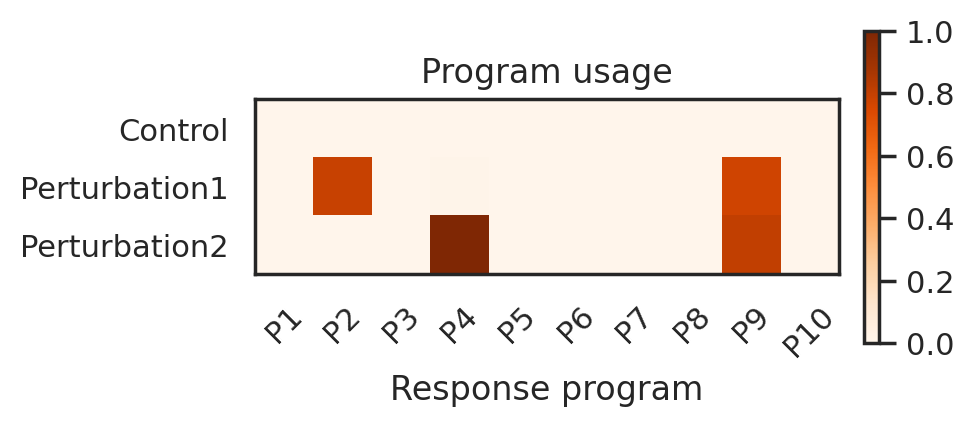

In [32]:
df_usage = plot_program_usage(
    cellcap=cellcap,
    adata=adata,
    perturbation_key='Condition',
)

Perturbation1


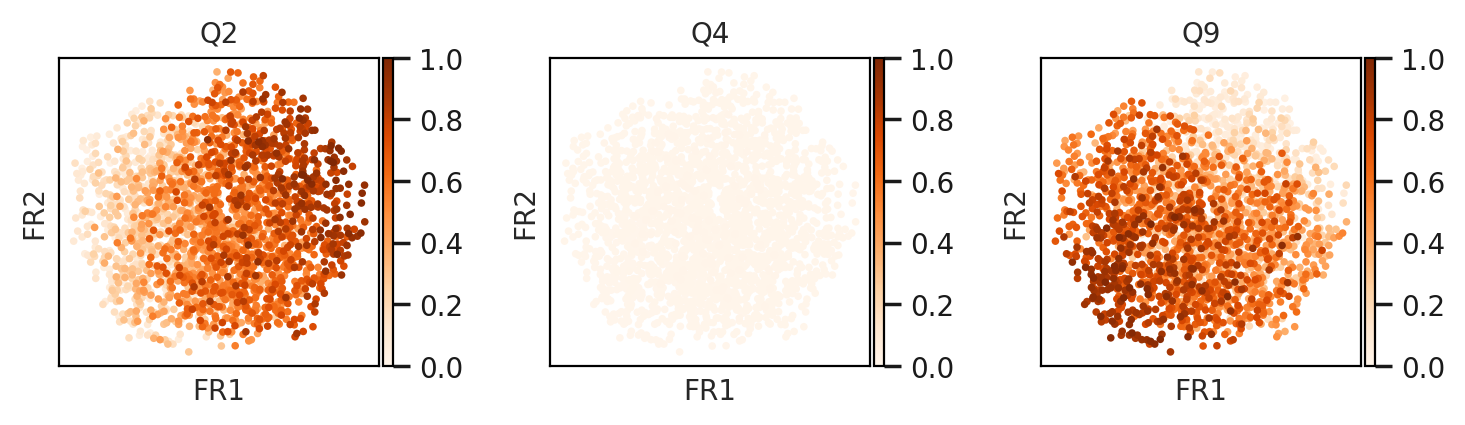

Perturbation2


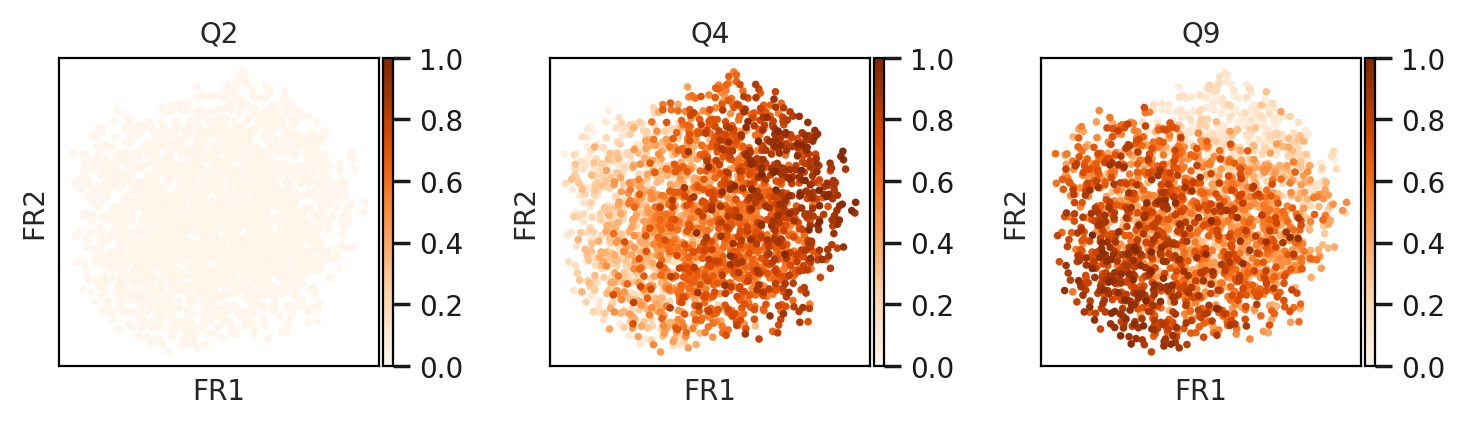

In [33]:
n_prog = 10
attention = ['Q'+str(i) for i in range(1,n_prog+1)]
for d in ['Perturbation1','Perturbation2']:
    ad = adata[adata.obs['Condition']==d]
    attn = pd.DataFrame(ad.obsm['X_h_scaled'])
    attn.columns = attention

    for a in attention:
        x = attn[a].values
        ad.obs[a]=x
    
    print(d)
    sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True,figsize=(2,2),fontsize=10)
    sc.pl.draw_graph(ad, color=['Q2','Q4','Q9'],ncols=3, cmap='Oranges',vmin=0,vmax=1,size=30)

We next calculate the pearsone correlation coefficient to evaluate if response amplitutes of learned programs correlate or anti-correlate with pseudotime. Here, we use perturbation 1 as example.

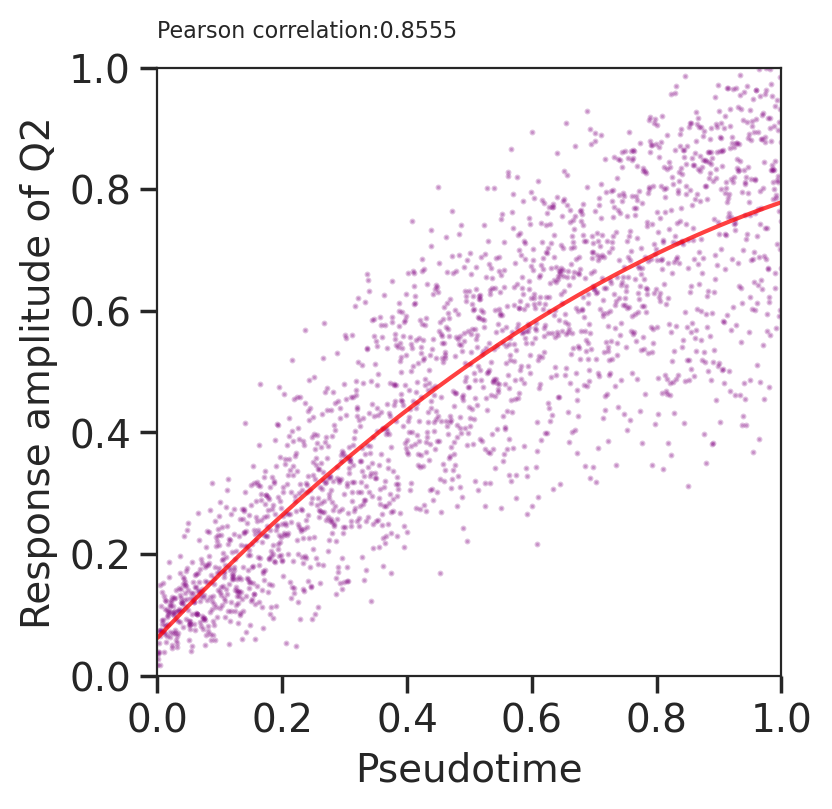

In [34]:
import scipy
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True)
p1 = adata[adata.obs['Condition']=='Perturbation1']

#Q2 is specific to perturbation 1
df = pd.DataFrame.from_dict({'Ptime':p1.obs['Pseudotime'].values,'Q2':p1.obsm['X_h_scaled'][:,(2-1)]})

#fit a poly line
model = np.poly1d(np.polyfit(df['Ptime'], df['Q2'], 2))
polyline = np.linspace(0, 1, 50)

sns.set_style("ticks")
plt.scatter(df['Ptime'], df['Q2'], color='purple',s=5,marker=".",alpha=0.25)
plt.plot(polyline, model(polyline), color='red',alpha=0.75)
plt.ylim(0,1.0)
plt.xlim(0,1.0)
plt.grid(False)
plt.title("")
plt.ylabel("Response amplitude of Q2")
plt.xlabel("Pseudotime")
plt.text(0.0, 1.05, 'Pearson correlation:'+str(round(scipy.stats.pearsonr(df['Ptime'], df['Q2'])[0],4)), fontsize=8)
plt.show()

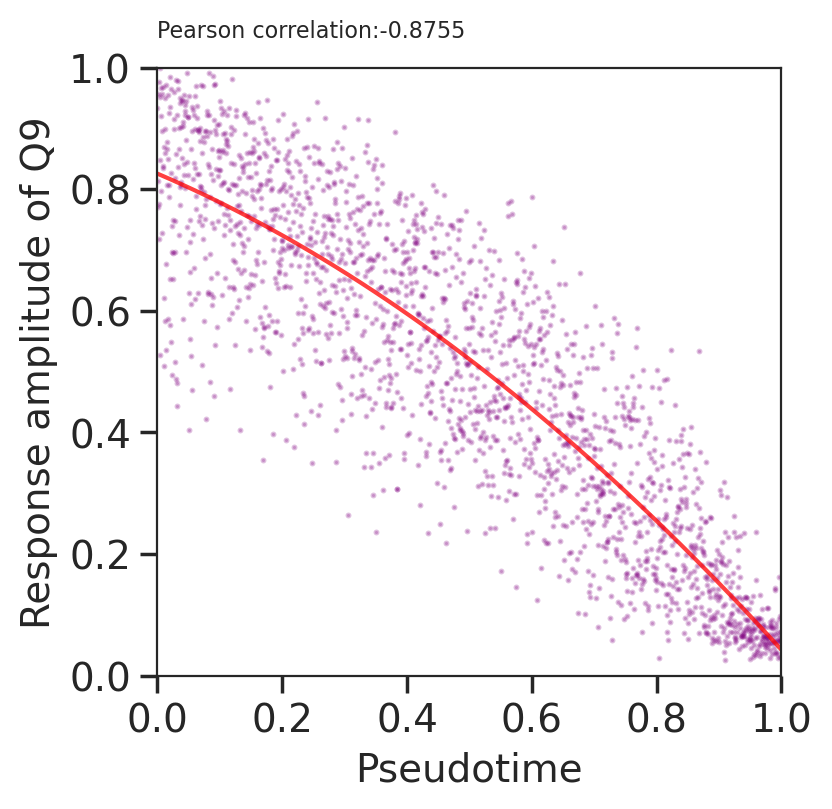

In [35]:
#Q9 is the shared program
df = pd.DataFrame.from_dict({'Ptime':p1.obs['Pseudotime'].values,'Q9':p1.obsm['X_h_scaled'][:,(9-1)]})

#fit a poly line
model = np.poly1d(np.polyfit(df['Ptime'], df['Q9'], 2))
polyline = np.linspace(0, 1, 50)

sns.set_style("ticks")
plt.scatter(df['Ptime'], df['Q9'], color='purple',s=5,marker=".",alpha=0.25)
plt.plot(polyline, model(polyline), color='red',alpha=0.75)
plt.ylim(0,1.0)
plt.xlim(0,1.0)
plt.grid(False)
plt.title("")
plt.ylabel("Response amplitude of Q9")
plt.xlabel("Pseudotime")
plt.text(0.0, 1.05, 'Pearson correlation:'+str(round(scipy.stats.pearsonr(df['Ptime'], df['Q9'])[0],4)), fontsize=8)
plt.show()

We can conclude that CellCap captures decent correlation and anti-correlation for perturbation1-specific program and the shared one (with PCC 0.8555 and -0.8755).